# Theme 5 - Fluid-Rock Interactions and the Sub-Seafloor Biosphere
OOI Data Labs Education Nuggets

_Written by Lori Garzio, Rutgers University_

_Disclaimer: data used in this example were downloaded on Nov 7, 2019. The file format and/or contents could have changed._

**Objective**: Demonstrate how to download Vent Fluid Temperature and Bottom Pressure and Tilt data from the OOI system using the Machine-to-Machine (M2M) interface, downsample the dataset,and export as a .csv file.

In [1]:
# Notebook Setup
import requests
import os
import re
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/Users/lgarzio/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


## 1. Request Data from OOINet

* **Cabled ASHES Vent Field**
    * Diffuse Vent Fluid 3-D Temperature Array
        * Instrument: RS03ASHS-MJ03B-07-TMPSFA301
        * Delivery method: streamed
        * Data stream: tmpsf_sample
        * Parameter name: temperature01
    * Bottom Pressure and Tilt
        * Instrument: RS03ASHS-MJ03B-09-BOTPTA304
        * Delivery method: streamed
        * Data stream: botpt_nano_sample
        * Parameter name: bottom_pressure
    * Time range: 2017-09-03T06:00 to 2017-09-05T00:00

The **request_data** function below sends data requests with inputs specified by the user to OOINet and returns the THREDDs urls where the downloaded data files can be found.

In [2]:
# enter your OOI API username and token, and directory where output .csv files are saved
API_USERNAME = ''
API_TOKEN = ''
save_dir = '/Users/lgarzio/Documents/OOI/Nuggets/'

In [3]:
def request_data(reference_designator, method, stream, start_date=None, end_date=None):
    site = reference_designator[:8]
    node = reference_designator[9:14]
    instrument = reference_designator[15:]

    # Create the request URL
    api_base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'
    data_request_url = '/'.join((api_base_url, site, node, instrument, method, stream))

    # All of the following are optional, but you should specify a date range
    params = {
        'format': 'application/netcdf',
        'include_provenance': 'true',
        'include_annotations': 'true'
    }
    if start_date:
        params['beginDT'] = start_date
    if end_date:
        params['endDT'] = end_date

    # Make the data request
    r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
    data = r.json()

    # Return just the THREDDS URL
    return data['allURLs'][0]

Now, use that **request_data** function to download data for this instrument. You only need to do this once! These lines are commented out to prevent accidental re-submission of data requests.

In [4]:
# TMPSF_url = request_data('RS03ASHS-MJ03B-07-TMPSFA301', 'streamed', 'tmpsf_sample',
#                          '2017-09-03T06:00:00.000Z', '2017-09-05T00:00:00.000Z')

# BOTPT_url = request_data('RS03ASHS-MJ03B-09-BOTPTA304', 'streamed', 'botpt_nano_sample',
#                          '2017-09-03T06:00:00.000Z', '2017-09-05T00:00:00.000Z')

# print('TMPSF_url = %s' %TMPSF_url)
# print('BOTPT_url = %s' %BOTPT_url)

## 2. Load Data Files

Copy the links to the THREDDs catalog above that resulted from the **request_data** function (to avoid re-requesting the data). Note: the url must be surrounded by quotations. 

**Note**: this data request may take a while to fulfill because it's a very dense dataset. Later on we will calculate minute-averaged data to make the dataset more manageable.

In [5]:
TMPSF_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/lgarzio@marine.rutgers.edu/20191107T203352246Z-RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample/catalog.html'
BOTPT_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/lgarzio@marine.rutgers.edu/20191107T203352413Z-RS03ASHS-MJ03B-09-BOTPTA304-streamed-botpt_nano_sample/catalog.html'

The **get_data** function below:
* selects the appropriate datasets in a THREDDs catalog by selecting NetCDF files and removing collocated datasets (if provided)
* creates an empty dictionary with placeholders to populate with data just for variables of interest
* creates another dictionary to store the units for the variables of interest
* opens the dataset(s), extracts the data and units for the variables of interest and adds them to the dictionaries
* converts the data dictionary to a dataframe
* returns the dataframe and the dictionary containing the variable units. 

This type of function is most useful when working with multiple large/dense datasets (such as these cabled datasets), but is also fine for working with smaller datasets.

In [6]:
def get_data(url, vars):
    # Function to grab all data from specified directory
    tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
    dataset = requests.get(url).text
    ii = re.findall(r'href=[\'"]?([^\'" >]+)', dataset)
    # x = re.findall(r'(ooi/.*?.nc)', dataset)
    x = [y for y in ii if y.endswith('.nc')]
    for i in x:
        if i.endswith('.nc') == False:
            x.remove(i)
    for i in x:
        try:
            float(i[-4])
        except:
            x.remove(i)
    # dataset = [os.path.join(tds_url, i) for i in x]
    datasets = [os.path.join(tds_url, i.split('=')[-1]) for i in x]

    # remove collocated data files if necessary
    catalog_rms = url.split('/')[-2][20:]
    selected_datasets = []
    for d in datasets:
        if catalog_rms == d.split('/')[-1].split('_20')[0][15:]:
            selected_datasets.append(d)

    # create a dictionary to populate with data from the selected datasets
    data_dict = {'time': np.array([], dtype='datetime64[ns]')}
    unit_dict = {}
    for v in vars:
        data_dict.update({v: np.array([])})
        unit_dict.update({v: []})

    for sd in selected_datasets:
        ds = xr.open_dataset(sd, mask_and_scale=False)
        data_dict['time'] = np.append(data_dict['time'], ds['time'].values)
        for var in vars:
            data_dict[var] = np.append(data_dict[var], ds[var].values)
            units = ds[var].units
            if units not in unit_dict[var]:
                unit_dict[var].append(units)

    # convert dictionary to a dataframe
    df = pd.DataFrame(data_dict)
    df.sort_values(by=['time'], inplace=True)  # make sure the timestamps are in ascending order

    return df, unit_dict

In [7]:
# Specify the variable(s) of interest and get the data from the datasets
TMPSF_vars = ['temperature01']
BOTPT_vars = ['bottom_pressure']

TMPSF_data, TMPSF_units = get_data(TMPSF_url, TMPSF_vars)
BOTPT_data, BOTPT_units = get_data(BOTPT_url, BOTPT_vars)
print(TMPSF_units)
print(BOTPT_units)

{'temperature01': ['ºC']}
{'bottom_pressure': ['psia']}


In [8]:
# print the first few lines of data for each dataset
TMPSF_data.head()

,time,temperature01
0,2017-09-03 06:00:00.355244544,4.2996
1,2017-09-03 06:00:10.357481984,4.3022
2,2017-09-03 06:00:20.357473792,4.3161
3,2017-09-03 06:00:30.357431808,4.3258
4,2017-09-03 06:00:40.353981440,4.3308


In [9]:
BOTPT_data.head()

,time,bottom_pressure
0,2017-09-03 06:00:00.000000000,2277.596436
1,2017-09-03 06:00:00.050000384,2277.598877
2,2017-09-03 06:00:00.099999744,2277.600830
3,2017-09-03 06:00:00.150000128,2277.596191
4,2017-09-03 06:00:00.200000000,2277.596680


## Quick Data Plots
Make some quick plots of these datasets. First, we will calculate minute averages to make the datasets more manageable.

In [10]:
# rename and add units to the columns
TMPSF_data = TMPSF_data.rename(columns={'temperature01': 'Temperature (deg_C)'})

# calculate minute averages
TMPSF_min = TMPSF_data.resample('T', on='time').mean().dropna(how='all').reset_index()
TMPSF_min.head()

,time,Temperature (deg_C)
0,2017-09-03 06:00:00,4.320283
1,2017-09-03 06:01:00,4.401900
2,2017-09-03 06:02:00,4.421850
3,2017-09-03 06:03:00,4.420033
4,2017-09-03 06:04:00,4.513967


In [11]:
# rename and add units to the columns
BOTPT_data = BOTPT_data.rename(columns={'bottom_pressure': 'Bottom Pressure ({})'.format(BOTPT_units['bottom_pressure'][0])})

# calculate minute averages
BOTPT_min = BOTPT_data.resample('T', on='time').mean().dropna(how='all').reset_index()
BOTPT_min.head()

,time,Bottom Pressure (psia)
0,2017-09-03 06:00:00,2277.598255
1,2017-09-03 06:01:00,2277.596412
2,2017-09-03 06:02:00,2277.595240
3,2017-09-03 06:03:00,2277.593599
4,2017-09-03 06:04:00,2277.594007


Now, plot the minute-averaged data.

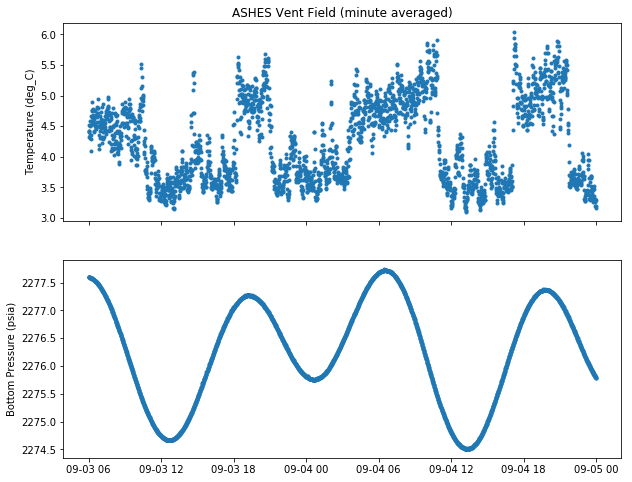

In [12]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(10, 8))
ax1.plot(TMPSF_min['time'], TMPSF_min['Temperature (deg_C)'], '.')
ax2.plot(BOTPT_min['time'], BOTPT_min['Bottom Pressure (psia)'], '.')
ax1.set_ylabel('Temperature (deg_C)')
ax2.set_ylabel('Bottom Pressure ({})'.format(BOTPT_units['bottom_pressure'][0]))
ax1.set_title('ASHES Vent Field (minute averaged)');

Let's merge the datasets into a single dataframe and plot the variables on the same graph.

In [13]:
merge = pd.merge(TMPSF_min, BOTPT_min, on='time', how='outer')
merge.sort_values(by=['time'], inplace=True)  # make sure the timestamps are in ascending order
merge.head()

,time,Temperature (deg_C),Bottom Pressure (psia)
0,2017-09-03 06:00:00,4.320283,2277.598255
1,2017-09-03 06:01:00,4.401900,2277.596412
2,2017-09-03 06:02:00,4.421850,2277.595240
3,2017-09-03 06:03:00,4.420033,2277.593599
4,2017-09-03 06:04:00,4.513967,2277.594007


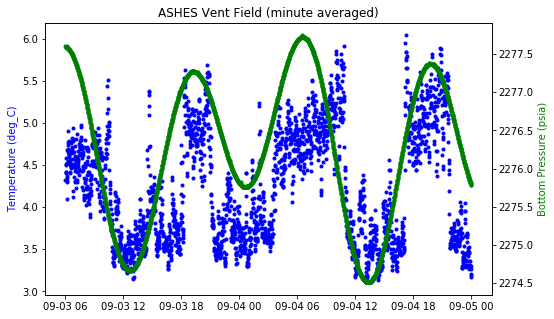

In [14]:
fig, ax1 = plt.subplots(figsize=(8,5))
ax2 = ax1.twinx()
ax1.plot(merge['time'], merge['Temperature (deg_C)'], 'b.', label='Temp')
ax2.plot(merge['time'], merge['Bottom Pressure (psia)'], 'g.', label='Pressure')
ax1.set_ylabel('Temperature (deg_C)', color='b')
ax2.set_ylabel('Bottom Pressure (psia)', color='g')
ax1.set_title('ASHES Vent Field (minute averaged)');

## 3. Export to csv
Export the minute-averaged dataset to a .csv file.

In [15]:
merge.to_csv(os.path.join(save_dir, 'Theme5_ASHES_vent_fluid_temps_tidal_signal.csv'), index=False)